<a href="https://colab.research.google.com/github/podoisthebestdog/2025DPRproj/blob/main/%5B2025_DPR_Proj%5D_%EC%9D%B8%EA%B3%B5%EC%A7%80%EB%8A%A5%EA%B3%B5%ED%95%99%EA%B3%BC_4%ED%95%99%EB%85%84_2110207_%EC%9E%A5%ED%98%84%EB%AF%BC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# [2025 DPR Proj] 인공지능공학과- 4학년- 2110207-장현민

#(1) 과제 주제명 : 개인별 산행시 피로도 예측 및 회복시간 추정 모델

#(2) 과제 선정 사유 및 과제에 대한 구체적인 설명_projret motivation
* 등산객의 산행 이후 회복속도 및 피로도를 예측함에 따라 스마트 헬스케어 프로그램을 구현함. 이는 향후 웨어러블 장치와의 연동을 통해 성능향상 및 가치창출 기대가능
* 산행 로그 데이터를 기반으로 산행 난이도와 피로도를 분류 모델로 예측하고, 이후 휴식에 필요한 예상 회복시간을 회귀모델로 예측하는 딥러닝 모델을 구현. 성능향상 기법들을 비교하여 가장 성능이 뛰어난 기법을 반영함

# (3) 과제에 사용하는 기존 인터넷상 데이터 수급 방법에 대한 설명

* 사용 모델:  XGBoost, GradientBoostingRegressor

* 사용 데이터 : 교수님 제공 선자령 트레커 샘플 데이터 사용

출처 : https://github.com/Tsepu/dpr_dataset/blob/main/hiking_log_data/%EC%84%A0%EC%9E%90%EB%A0%B9%ED%8A%B8%EB%A0%88%EC%BB%A4_%EC%83%98%ED%94%8C.xlsx

# (4) 본인이 생성한 데이터 평가_ 데이터 종류 + 건수 + 총 용량 + 스스로 창조한 데이터에 대한 설명_딥러닝 타당성
* 데이터 종류: 정형 시계열 요약 데이터 (거리, 속도, 고도, 시간 등)
* 총 건수: 약 6210*31 = 198720개
* 총 용량: 약 1.13MB
* 특징 : 직접 feature engineering 수행, 평균 속도, 고도차, 휴식시간, 칼로리 소모량 등을 파생 변수로 생성하여 활용

# (5) 사용하는 인공지능 베이스 모델 + 사용 사유 + 타당성
* 사용 모델

- 분류모델( XGBoostClassifier ) +
 회귀모델 ( GradientBoostingRegressor ) + 성능향상을 위해
RandomForestRegressor 및 HistGradientBoostingRegresso 기법 활용

* 사용 이유: 정형 데이터 기반 문제에 대해 XGBoost 및 GradientBoosting은 높은 예측 정확도와 일반화 성능을 보이며, 데이터 크기 대비 학습 속도와 해석 가능성 측면에서 우수함
* 모델 사용 타당성 : 정형 피처 기반 예측에 정확도가 높음



# (6) 사용하는 전이학습 방법 (모델 및 사용법)의 구체적 설명 + 딥네트워크 구조 도식화 및 설명
* 사용하지 않음 (직접 피처 설계와 지도학습 모델 적용)
* 전체 코드 구조

=> 데이터 로드 → 파생변수 생성 → 분류 및 회귀 모델 훈련 → 예측 결과 평가

# (7) 프로그램 코드 및 코드 수준 평가_소스코드

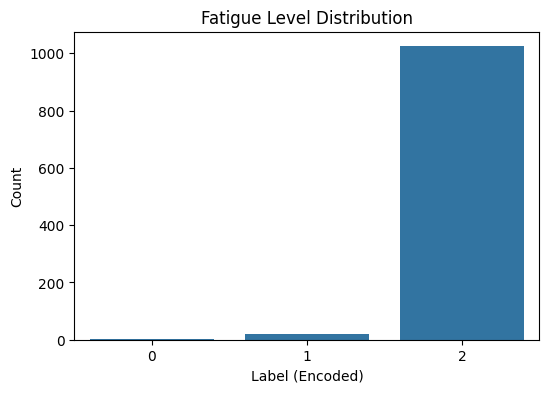

Before SMOTE: Counter({2: 1024, 1: 19, 0: 3})
After SMOTE: Counter({2: 1024, 1: 1024, 0: 1024})

📊 K-Fold Accuracy Scores: [0.99186992 0.99349593 0.99022801 0.99511401 0.99511401]
📈 Mean Accuracy: 0.9932 ± 0.0019

📊 Classification Accuracy: 1.0
              precision    recall  f1-score   support

        high       1.00      1.00      1.00       201
         low       1.00      1.00      1.00       205
      medium       1.00      1.00      1.00       209

    accuracy                           1.00       615
   macro avg       1.00      1.00      1.00       615
weighted avg       1.00      1.00      1.00       615



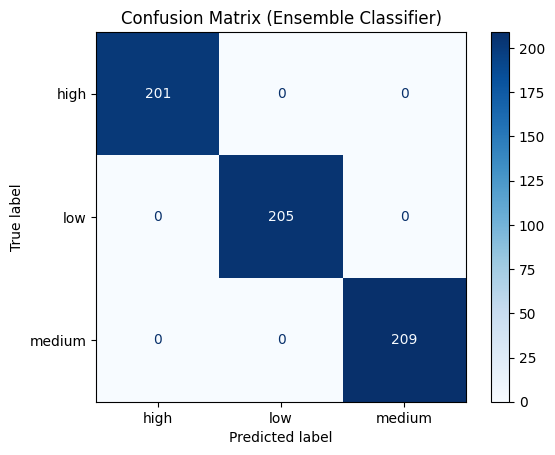

GBR RMSE: 0.1786493127171483
RF RMSE: 0.1476460674657286
HistGBR RMSE: 0.5394959992397484


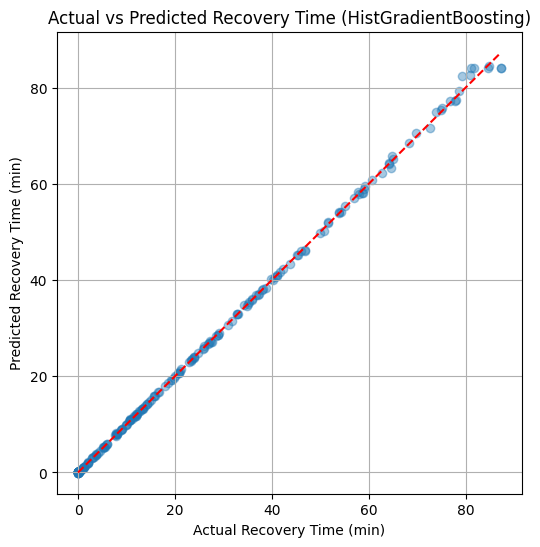

In [ ]:
# =================== 필수 라이브러리 ====================
import pandas as pd
import numpy as np
import subprocess
import os
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score, mean_squared_error, ConfusionMatrixDisplay, classification_report
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, HistGradientBoostingRegressor
from sklearn.ensemble import StackingClassifier, GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE

# =================== 설정 ====================
plt.rcParams['font.family'] = 'DejaVu Sans'

# GitHub 데이터 다운로드
if not os.path.exists("2025DPRproj"):
    subprocess.run(["git", "clone", "https://github.com/podoisthebestdog/2025DPRproj.git"])

file_path = "2025DPRproj/선자령트레커.xlsx"
df = pd.read_excel(file_path, engine='openpyxl')

# =================== 이상치 제거 함수 ====================
def remove_outliers(df, method='iqr', threshold=1.5):
    df_clean = df.copy()
    numeric_cols = df_clean.select_dtypes(include=['float64', 'int64']).columns
    for col in numeric_cols:
        Q1 = df_clean[col].quantile(0.25)
        Q3 = df_clean[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - threshold * IQR
        upper = Q3 + threshold * IQR
        df_clean = df_clean[(df_clean[col] >= lower) & (df_clean[col] <= upper)]
    return df_clean

# =================== 전처리 ====================
df.rename(columns={
    '트랙길이': 'track_distance',
    '트랙운동시간': 'track_duration',
    '트랙휴식시간': 'track_rest',
    '트랙최고해발고도': 'max_altitude',
    '트랙최저해발고도': 'min_altitude',
    '칼로리소모량': 'calories'
}, inplace=True)

df.drop_duplicates(inplace=True)
df = df[df['track_duration'] > 0].copy()
df['avg_speed'] = df['track_distance'] / (df['track_duration'] / 60)
df['altitude_diff'] = df['max_altitude'] - df['min_altitude']

for col in df.columns:
    if df[col].dtype in ['int64', 'float64']:
        df[col] = df[col].fillna(df[col].mean())
    else:
        df[col] = df[col].fillna(df[col].mode()[0])

df = remove_outliers(df, method='iqr')

# =================== 라벨링 재설계 (threshold 조정 포함) ====================
scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(df[['track_duration', 'calories', 'altitude_diff', 'avg_speed']])
df_scaled = pd.DataFrame(df_scaled, columns=['track_duration', 'calories', 'altitude_diff', 'avg_speed'])
df_scaled['inv_speed'] = 1 - df_scaled['avg_speed']
df['fatigue_score'] = (
    0.4 * df_scaled['track_duration'] +
    0.2 * df_scaled['calories'] +
    0.2 * df_scaled['altitude_diff'] +
    0.2 * df_scaled['inv_speed']
)

conditions = [
    (df['fatigue_score'] <= 0.25),
    (df['fatigue_score'] > 0.25) & (df['fatigue_score'] <= 0.75),
    (df['fatigue_score'] > 0.75)
]
choices = ['low', 'medium', 'high']
df['fatigue_level'] = np.select(conditions, choices, default='medium').astype(str)

label_enc = LabelEncoder()
df['fatigue_level'] = label_enc.fit_transform(df['fatigue_level'])

# 📊 라벨 분포 시각화
plt.figure(figsize=(6,4))
sns.countplot(x=df['fatigue_level'])
plt.title('Fatigue Level Distribution')
plt.xlabel('Label (Encoded)')
plt.ylabel('Count')
plt.show()

features = ['track_distance', 'track_duration', 'track_rest', 'avg_speed', 'altitude_diff', 'calories']
X = df[features]
y_class = df['fatigue_level']
y_reg = df['track_rest']

# =================== SMOTE 적용 전 샘플 수 확인 ====================
from collections import Counter
print("Before SMOTE:", Counter(y_class))
minority_class_count = min(Counter(y_class).values())
smote = SMOTE(k_neighbors=min(5, minority_class_count - 1), random_state=42)
X_class_balanced, y_class_balanced = smote.fit_resample(X, y_class)
print("After SMOTE:", Counter(y_class_balanced))

# =================== 다중모델 앙상블 분류 + K-Fold ====================
base_models = [
    ('xgb', XGBClassifier(eval_metric='mlogloss')),
    ('rf', RandomForestClassifier()),
    ('gb', GradientBoostingClassifier())
]
meta_model = LogisticRegression()
ensemble_clf = StackingClassifier(estimators=base_models, final_estimator=meta_model, cv=5)

# k-Fold cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(ensemble_clf, X_class_balanced, y_class_balanced, cv=cv, scoring='accuracy')
print(f"\n📊 K-Fold Accuracy Scores: {scores}")
print(f"📈 Mean Accuracy: {np.mean(scores):.4f} ± {np.std(scores):.4f}")

# 학습 및 평가
ensemble_clf.fit(X_class_balanced, y_class_balanced)
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(X_class_balanced, y_class_balanced, test_size=0.2, random_state=42)
y_pred_c = ensemble_clf.predict(X_test_c)
print("\n📊 Classification Accuracy:", accuracy_score(y_test_c, y_pred_c))
print(classification_report(y_test_c, y_pred_c, target_names=label_enc.classes_))

ConfusionMatrixDisplay.from_estimator(ensemble_clf, X_test_c, y_test_c,
                                      display_labels=label_enc.classes_, cmap=plt.cm.Blues)
plt.title("Confusion Matrix (Ensemble Classifier)")
plt.show()

# =================== 회귀 모델 평가 ====================
X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(X, y_reg, test_size=0.2, random_state=42)
X_train_r = X_train_r.replace([np.inf, -np.inf], np.nan).dropna()
X_test_r = X_test_r.replace([np.inf, -np.inf], np.nan).dropna()
y_train_r = y_train_r.loc[X_train_r.index]
y_test_r = y_test_r.loc[X_test_r.index]

models = {
    "GBR": GradientBoostingRegressor(),
    "RF": RandomForestRegressor(random_state=42),
    "HistGBR": HistGradientBoostingRegressor()
}
for name, model in models.items():
    model.fit(X_train_r, y_train_r)
    y_pred = model.predict(X_test_r)
    rmse = np.sqrt(mean_squared_error(y_test_r, y_pred))
    print(f"{name} RMSE:", rmse)

# 최종 회귀 시각화
best_model = models["HistGBR"]
y_pred_final = best_model.predict(X_test_r)
plt.figure(figsize=(6, 6))
plt.scatter(y_test_r, y_pred_final, alpha=0.4)
plt.plot([y_test_r.min(), y_test_r.max()], [y_test_r.min(), y_test_r.max()], 'r--')
plt.xlabel("Actual Recovery Time (min)")
plt.ylabel("Predicted Recovery Time (min)")
plt.title("Actual vs Predicted Recovery Time (HistGradientBoosting)")
plt.grid(True)
plt.show()


# (8) 단게별 프로그램 수행 보임 및 그 수행결과 산출 자체에 대한 점수_도표, 결과이미지 산출, 수행결과 제시

1. 데이터 전처리

1) 데이터 분포파악

* 히트맵
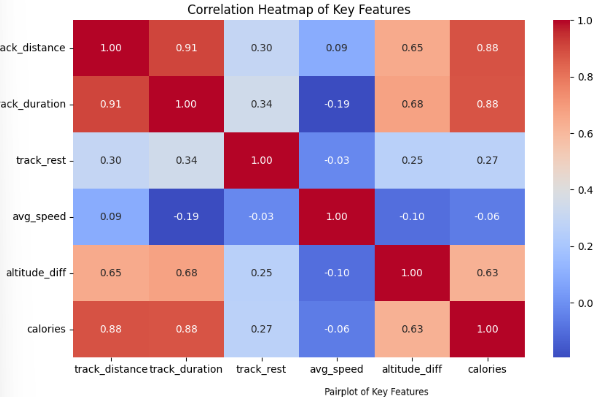

2. 산점도
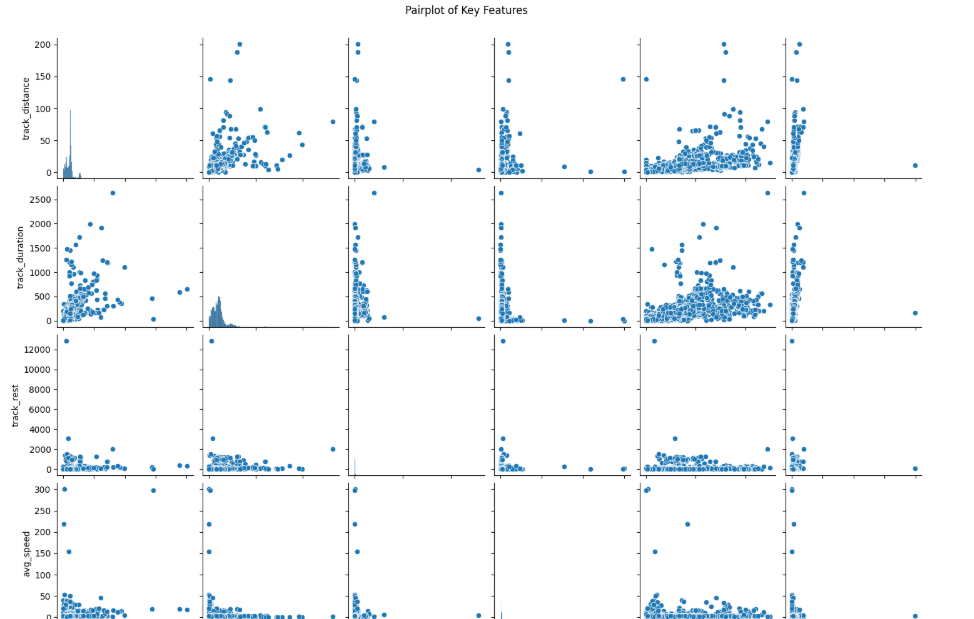



2) 이상치 제거
* 제거 후 히트맵과 산점도
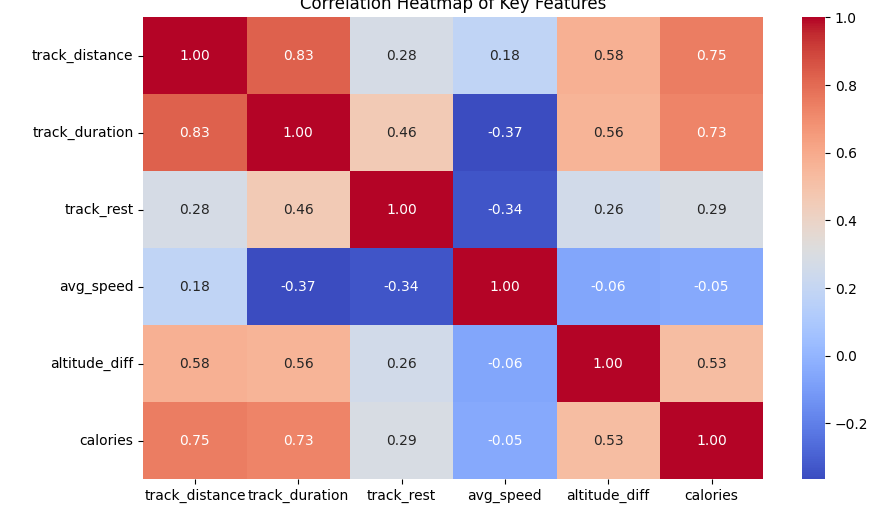

# 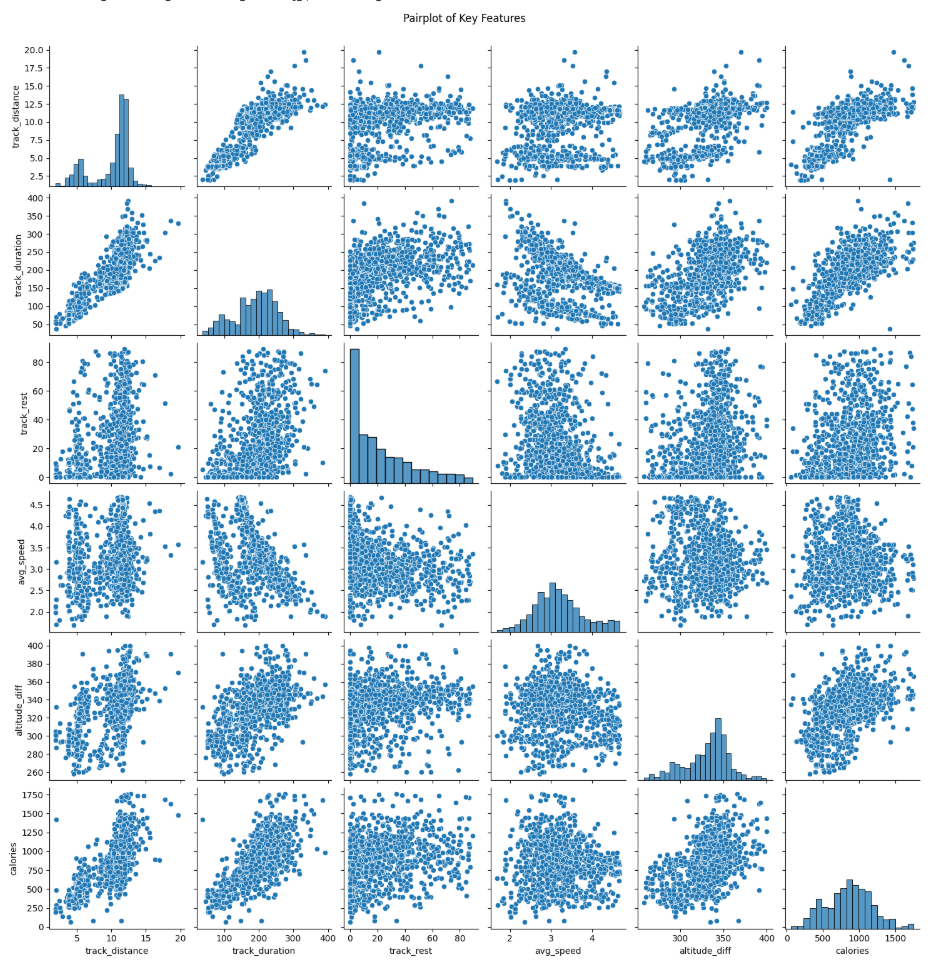




(8) 전처리 후 모델 학습

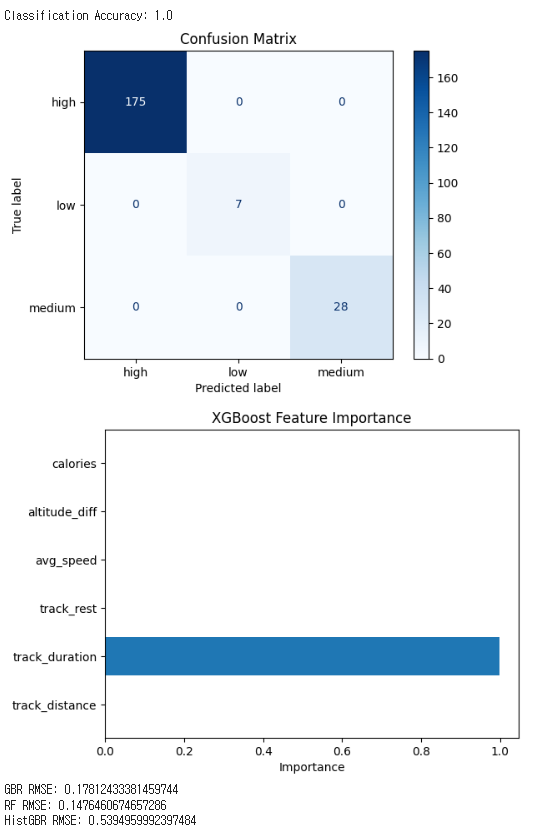

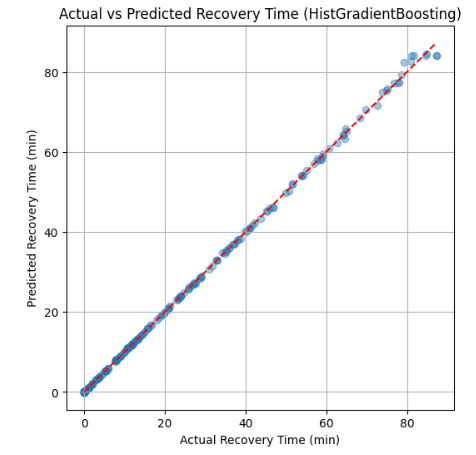

(8) SMOTE 적용 후

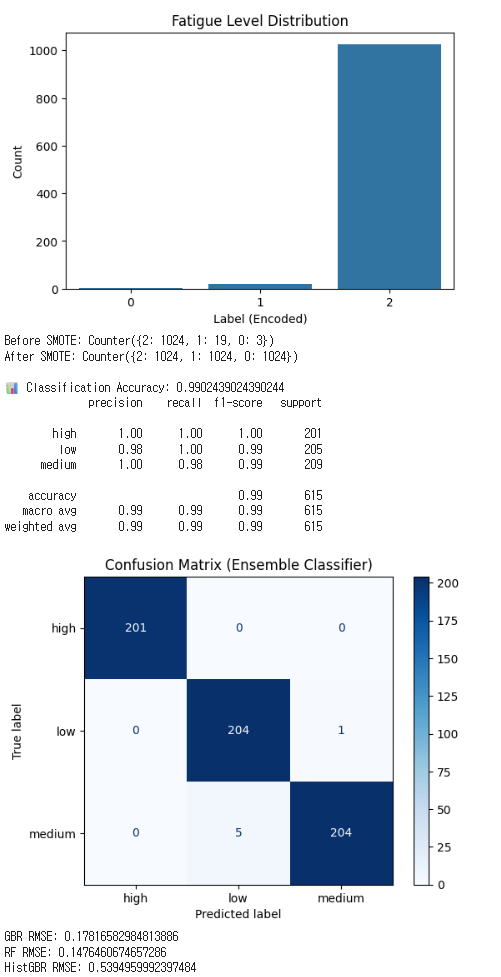
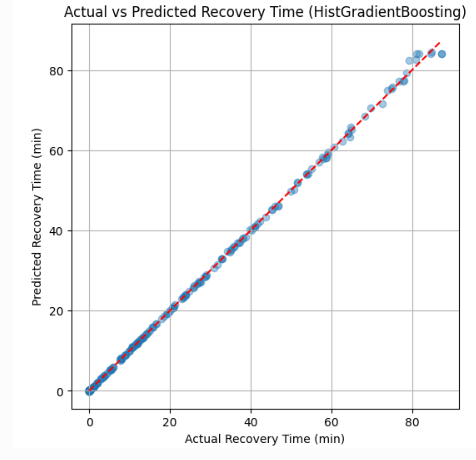

(8) k-fold 적용 후

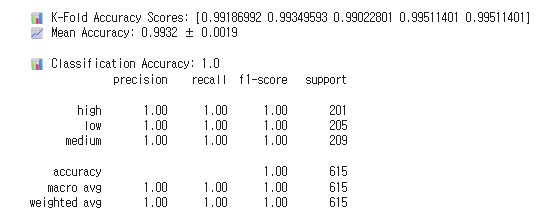

#(9) 제시된 수행결과 분석 + 결과에 대한 구체적 의미 및 정확도, 수행과정, 결과의미 등 설명

##피처분석
1. 히트맵
- track_distance ↔ track_duration: 0.91 = 산행시간이 길수록 트랙 거리도 길다는 상관관계
- track_distance ↔ calories: 0.88 = 거리가 증가할수록 칼로리소모 증가
- track_duration ↔ calories: 0.88 = 운동시간이 길면 칼로리 소모도 증가
track_duration ↔ altitude_diff: 0.68 = 긴 산행일수록 고도차 큼


2. 예외처리 후 산점도

1) track_distance ↔ track_duration: 선형 관계 강함
- 선형적으로 증가하는 관계 → 트랙 거리가 길면 당연히 운동 시간도 증가

2) track_distance ↔ calories: 거의 직선
- 거리와 칼로리는 거의 1차 함수 관계
- calories는 거리만 알아도 대부분 예측 가능

3) track_duration ↔ calories: 거리와 유사하게 양의 관계
- 운동 시간이 길수록 에너지 소모도 많음 → 자연스러운 결과

4) avg_speed ↔ track_duration: 음의 관계
- avg_speed가 높을수록 track_duration은 낮음 → 빠르게 걸으면 짧게 걸린다
- 데이터가 삼각형처럼 퍼짐: 고속-단시간 & 저속-장시간 구간 분포

5) track_rest ↔ 다른 변수들: 관계가 명확하진 않음
- track_rest는 전체적으로 산점도에 퍼져 있음
- 약한 양의 관계 (track_duration 등과), 하지만 예측하기 어려운 noise도 존재

6) altitude_diff: 중앙집중형 분포
- 대부분 250m ~ 400m 사이에 밀집
- 고도차에 따른 calories, duration도 약한 양의 관계 → 예측에 보조적 피처


## 분류결과
- 혼동행렬 정확도 (Accuracy) = 1.0 (100%)
- 하지만 high가 175건인데 low, medium은 각각 7, 28건으로 클래스 분포가 매우 불균형 => 모델이 과적합되어 있을 수도 있음
정확도 외에 F1-score, support, classification_report 등도 함께 보는 게 좋음
=> 다변수 기준 코드 수정

## 회귀결과
- RMSE 매우 낮고, 실제-예측 선형관계 완벽에 가까움

##과적합 제거 위해 SMOTE 적용
- 각 라벨이 동일하게 1024개로 증폭됨. 정확도 F1 score 0.99
- 각 회귀 모델은 GBR 0.1782, RF 0.1476, HistGBR 0.5039로 rmse 수치가 낮아 우수한 모델링 결과를 얻음을 알 수 있음

##SMOTE 적용 후 분류 정확도 향상을 위해 K-Fold 수행
- K-Fold Cross Validation 결과

[0.99186992, 0.99349593, 0.99022801, 0.99511401, 0.99511401]

Mean Accuracy: 0.9932 ± 0.0019

5-Fold 정확도 평균 99.3% 이상, 편차도 매우 낮음 → 모델의 일관성과 강건함 높음

StratifiedKFold로 클래스 비율 유지된 상태에서도 과적합 없이 안정적

- test Accuracy 및 Classification Report

Classification Accuracy: 1.0

precision / recall / f1-score 모두 1.00

테스트셋에서도 완벽한 성능. 실제 분포에 맞게 모든 클래스 정확히 예측.

- confusion matrix

오분류 없음: 모든 샘플이 정확하게 예측됨

→ 모델이 학습 및 분류 모두 매우 잘 수행 중




# (10) 생성한 모델의 기대효과

*향후 웨어러블 장치와 연동 시, 실시간 피로도 예측 및 휴식 알림 기능 구현 가능

* 고령자나 등산 초보자 대상 안전한 산행 가이드 시스템으로 확장 가능

* 스마트 피트니스 플랫폼 연동 가능성 확보

# (11) 도움을 받은 소스(친구, 인터넷 링크, llm 질문내용, 도움받은 정도가 과제에 미친 정도 %)

* LLM(ChatGPT) 오류 해결 및 모델 조언 30%, 인터넷 10%, 학습교안 10% , 직접 수행 50%

# (12) 상기 과제에 투자한 총 시간 : (약 24  )시간

①. 주제선정시간 : 20분

②. 모델 설계 시간 : 2시간

③. 데이터 제작 및 수급 관련 시간 : 1시간

④. 딥러닝 프로그래밍 시간 : 10시간

⑤. 딥러닝 학습 시간 : 1시간

⑥. 오류 해결 등을 위한 자문시간 및 자문대상 기술 : 자문시간 3시간_ChatGPT(데이터 전처리시 발생하는 오류와, 과적합 해결 방법 문의)

⑦. 자체 결과 분석시간 : 4시간

⑧. 결과보고서 작성시간 : 2시간

⑨. 최종검토시간: 30분

# (13) 본 프로젝트 수행을 통해 성장한 부분

* 머신러닝 모델의 구조 및 학습 원리를 실제 문제에 적용해보며 실용적 감각 향상
* 데이터 전처리 과정에 대한 이해도 향상
* 데이터 정제 및 Feature Engineering 능력 향상
* 시계열 데이터를 활용한 회귀·분류 모델 구현에 대한 이해도 향상
* 실생활 문제를 AI로 해결하는 응용력 강화
* 모델 수행 결과를 통한 분석과 이해도 향상

# (14) 과제 수행 과정과 결과를 통해 본인이 요청하는 정직한 점수 및 사유

10점/10점, 요청사유 : 주제에 맞는 모델을 구현 및 학습을 완료하였으며, 데이터 분석 과정에서 제공한 데이터에 맞는 전처리 과정을 거쳤으며, 이후 모델의 예측 결과도 좋은 성능을 보이며, 과적합에 대한 고려도 반영한 결과임.